# Research Question:  Can we improve Naive Bayes classification by adding a top-level class embedding all 2 speed limit street signs ?

We have seen overall good performance by the Naive Bayes algorithm, with accuracy of 75.6% and a confusion matrix depicting very good precision and recall score. However we could not help but to notice that the most frequent error that occured with the Naive Bayes algorithm was when he was predicting the speed street-signs. 

Therefore, we had an idea: why not create a new class called "speed limit sign" and then, add a second model that would decide what kind of speed limit sign has been predicted. This could be summed up with this graph:

![alt](static\models_hierarchy.png)

Our inspiration for this idea was the already existing [ImageNet](http://www.image-net.org/) dataset where you have a hiearchy of concepts with nodes and classes. To some extent, could this idea be applied to Naïve Bayes ? 

## Imports

In [ ]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import numpy as np
import sklearn.preprocessing
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, ComplementNB
from tqdm import tqdm
from pomegranate import *
import networkx 
import imblearn

# Import local file
from utils import *

# Constants
Y_TRAIN_ONE_VS_ALL_BASENAME =  "y_train_smpl_{}.csv"
SEED = 42
TEST_SIZE = 0.33
NUM_CLASSES = 10
DISCRETIZATION_BINS_NUMBER = 10
NUM_OF_FIELDS_TO_KEEP = 10
NUM_FIELDS = 10
NUM_OF_TENS_OF_FIELDS_TO_TRAIN = 200
IMAGE_SHAPE = (48, 48)
CLASSES = {
    0: "speed_limit_60",
    1: "speed_limit_80",
    2: "speed_limit_80_lifted",
    3: "right of way at crossing",
    4: "right of way in general",
    5: "give way",
    6: "stop",
    7: "no speed limit general",
    8: "turn right down",
    9: "turn left down"
}

## Class Definition

For the modelisation of the two models, we will use a handmade class that will handle the manipulation of the "*street signs*" instances and the training/prediction procedures with two models as if they were only one.

In [ ]:
class HierarchyOfNaiveBayes():
    
    FIRST_CLASSES = {
        0: "speed_limit",
        #2: "speed_limit_80_lifted",
        3: "right of way at crossing",
        4: "right of way in general",
        5: "give way",
        6: "stop",
        7: "no speed limit general",
        8: "turn right down",
        9: "turn left down"
    }
    
    def __init__(self):
        self.first_model = MultinomialNB(fit_prior=True)
        self.second_model = BernoulliNB(fit_prior=True)
        
    def predict(self, X):
        y = []
        first_pred = self.first_model.predict(X)
        
        # select all X where prediction is 0
        street_signs_x = X[first_pred == 0]
        
        second_pred = self.second_model.predict(street_signs_x)
        
        first_pred[first_pred == 0] = second_pred
        
        return first_pred, second_pred
    
    def fit(self, X_train, y_train):
        
        # creating the new ground truths
        new_y_train = np.array(y_train)
        y_train_first = np.array(new_y_train)

        y_train_first[y_train_first == 1] = 0
        #y_train_first[y_train_first == 2] = 0

        #print("First model training launched...")
        self.first_model.fit(X_train, y_train_first)
        
        y_train_second = new_y_train[np.logical_and(y_train >= 0, y_train < 2)]
        
        #print("Second model training launched..")
        self.second_model.fit(X_train[np.logical_and(y_train >= 0, y_train < 2)], y_train_second)
        
    def score(self, X_test, y_test):
        
        new_y_test = np.array(y_test)
        new_y_test_first = np.array(new_y_test)
        new_y_test_first[new_y_test == 1] == 0
        
        new_y_test_second = new_y_test[np.logical_and(y_test >= 0, y_test < 2)]
        
        X_test_second = X_test[np.logical_and(y_test >= 0, y_test < 2)]
        
        print(self.first_model.score(X_test, new_y_test_first))
        print(self.second_model.score(X_test_second, new_y_test_second))

## Loading and preprocessing data

We now load and preprocess the data as before

In [ ]:
data = pd.read_csv("x_train_gr_smpl.csv")
ground_truth = pd.read_csv("y_train_smpl.csv")
ground_truth.columns=["prediction"]
df = pd.concat([data, ground_truth], axis=1)

Y_ONE_VS_ALL = {}
# loading all one_vs_rest ground-truth
for i in CLASSES.keys():
    tmp_gt = pd.read_csv(Y_TRAIN_ONE_VS_ALL_BASENAME.format(i))
    # In 1 vs all, the "negative" instances are makred with 1, the psositive with 0
    # We change this to the opposite for convenience purposes 
    Y_ONE_VS_ALL[i] = (tmp_gt + 1 )%2 #transform 0s into 1s and 1s into 0s

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    data, ground_truth, test_size=TEST_SIZE, random_state=SEED)

y_train_one_vs_all = {}
y_test_one_vs_all = {}

for i in CLASSES.keys():
    tmp_ground_truth = Y_ONE_VS_ALL[i]
    
    _, _, y_train_tmp, y_test_tmp = train_test_split(
    data, tmp_ground_truth, test_size=TEST_SIZE, random_state=SEED)
    
    y_train_one_vs_all[i] = y_train_tmp 
    y_test_one_vs_all[i] = y_test_tmp

X_train_dis_arr = X_train.apply(binarizedInputImage, axis=1)
X_test_dis_arr = X_test.apply(binarizedInputImage, axis=1)

Now performing feature selection:

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.svm import SVC
sm = SelectKBest(chi2, k=500).fit(X_train_dis_arr, y_train)
n_X_train_dis_arr = sm.transform(X_train_dis_arr)

n_X_test_dis_arr = sm.transform(X_test_dis_arr)


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

lsvc = LinearSVC(C=0.01, penalty="l1", dual=False, maxiter=5000).fit(n_X_train_dis_arr, y_train)
model = SelectFromModel(lsvc, prefit=True)

n_X_train_dis_arr = model.transform(n_X_train_dis_arr)

In [ ]:
n_X_test_dis_arr = model.transform(n_X_test_dis_arr)

## Training

It is now time to train our MultinomialNB model to see how it performs agains the BernoulliNB model of the other notebook.

In [ ]:
global_clf = MultinomialNB()
global_clf.fit(n_X_train_dis_arr, np.ravel(y_train))

In [ ]:
pred_global = global_clf.predict(n_X_test_dis_arr)
print(metrics.accuracy_score(y_test, pred_global))
print(metrics.confusion_matrix(y_test, pred_global))

Now that our data is correctly loaded, we will instantiate our Model:

In [ ]:
model = HierarchyOfNaiveBayes()
model.fit(n_X_train_dis_arr, np.ravel(y_train.to_numpy()))

In [ ]:
preds, s_preds = model.predict(n_X_test_dis_arr)
print(metrics.accuracy_score(y_test.to_numpy(), preds))
print(metrics.confusion_matrix(y_test, preds))

We see a little but existing improvement in the prediction accuracy ! We will now compare the model for 200 different numbers of attributes to see if this hypothesis is consistent.

In [44]:
res_base_model = []
res_composite_model = []

for i in tqdm(range(1, 201)):
    
    sm = SelectKBest(chi2, k=i*10).fit(X_train_dis_arr, y_train)
    n_X_train_dis_arr = sm.transform(X_train_dis_arr)
    n_X_test_dis_arr = sm.transform(X_test_dis_arr)
    
    global_clf = MultinomialNB()
    global_clf.fit(n_X_train_dis_arr, np.ravel(y_train))
    
    pred_global = global_clf.predict(n_X_test_dis_arr)
    res_base_model.append(metrics.accuracy_score(y_test, pred_global))
    
    model = HierarchyOfNaiveBayes()
    model.fit(n_X_train_dis_arr, np.ravel(y_train.to_numpy()))
    
    preds, s_preds = model.predict(n_X_test_dis_arr)
    res_composite_model.append(metrics.accuracy_score(y_test, preds))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:32<00:00,  2.16it/s]


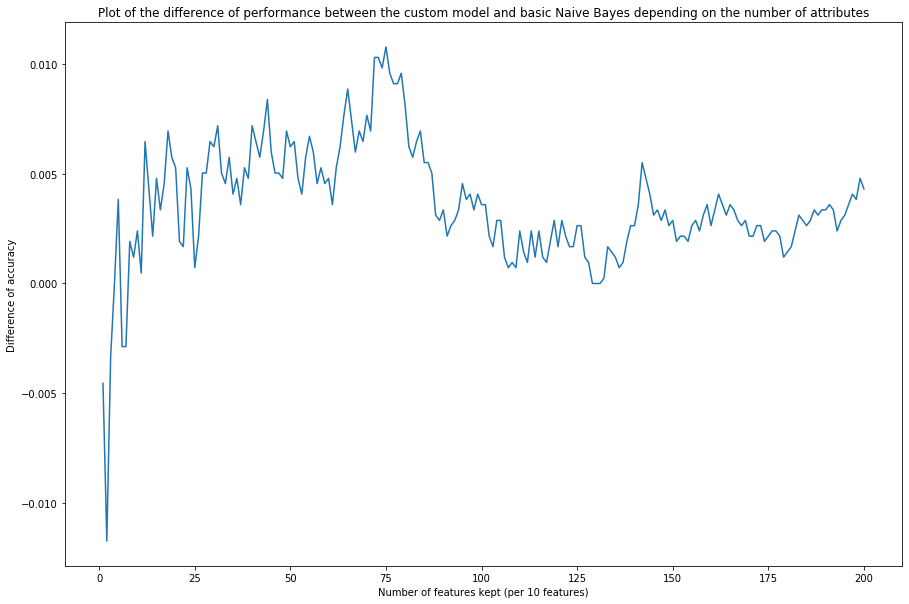

In [50]:
X = list(range(1,201))

plt.figure(figsize=(15,10))
plt.title("Plot of the difference of performance between the custom model and basic Naive Bayes depending on the number of attributes")
plt.xlabel("Number of features kept (per 10 features)")
plt.ylabel("Difference of accuracy")
plt.plot(X, [rcn - rbn for rcn, rbn in zip(res_composite_model, res_base_model)])
#plt.plot(X, res_base_model)
#plt.plot(X, res_composite_model)

We can see in the above plot of the difference of performance between my custom model and basic Naïve Bayes:
when at first, it does not really improve anything, we can see it, with time, stabilizing around 0.5% of better predicition performance. This may be a clear sign that using a tree-like hierarchy of abstract concepts would help to have more precise Naïve Bayes predictions.

